In [1]:
!pip install keras

    100% |████████████████████████████████| 337kB 3.3MB/s ta 0:00:01


In [2]:
import sys
sys.path.append('/input/Mask_RCNN')

In [3]:
import os
import sys
import random
import math
import re
import time

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import csv
import imageio
import skimage
from config import Config
from skimage.morphology import label
from skimage.feature import canny
from skimage import exposure
from keras.callbacks import Callback
from skimage.morphology import binary_closing, binary_opening, disk, binary_dilation
from scipy.ndimage.morphology import binary_fill_holes
from sklearn.externals import joblib
from skimage.transform import PiecewiseAffineTransform, warp
from skimage.morphology import watershed
from skimage.filters import sobel

import utils
import model as modellib
import visualize
from model import log

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
class LossHistory(Callback):  
    def on_train_begin(self, logs={}):
        self.batch_id = 0
        self.epoch_id = 0

    def on_batch_end(self, batch, logs={}):
        self.batch_id += 1
        ctx.channel_send('loss', x=self.batch_id, y=float(logs.get('loss')))
        ctx.channel_send('rpn_class_loss', x=self.batch_id, y=float(logs.get('rpn_class_loss')))
        ctx.channel_send('rpn_bbox_loss', x=self.batch_id, y=float(logs.get('rpn_bbox_loss')))
        ctx.channel_send('mrcnn_class_loss', x=self.batch_id, y=float(logs.get('mrcnn_class_loss')))
        ctx.channel_send('mrcnn_bbox_loss', x=self.batch_id, y=float(logs.get('mrcnn_bbox_loss')))
        ctx.channel_send('mrcnn_mask_loss', x=self.batch_id, y=float(logs.get('mrcnn_mask_loss')))
    
    def on_epoch_end(self, batch, logs={}):
        self.epoch_id += 1
        ctx.channel_send('val_loss', x=self.epoch_id, y=float(logs.get('val_loss')))
        ctx.channel_send('val_rpn_class_loss', x=self.epoch_id, y=float(logs.get('val_rpn_class_loss')))
        ctx.channel_send('val_rpn_bbox_loss', x=self.epoch_id, y=float(logs.get('val_rpn_bbox_loss')))
        ctx.channel_send('val_mrcnn_class_loss', x=self.epoch_id, y=float(logs.get('val_mrcnn_class_loss')))
        ctx.channel_send('val_mrcnn_bbox_loss', x=self.epoch_id, y=float(logs.get('val_mrcnn_bbox_loss')))
        ctx.channel_send('val_mrcnn_mask_loss', x=self.epoch_id, y=float(logs.get('val_mrcnn_mask_loss')))

In [6]:
def train_valid_split(meta, validation_size, valid_category_ids=None):
    meta_train = meta[meta['is_train'] == 1]
    meta_train_split, meta_valid_split = split_on_column(meta_train,
                                                         column='vgg_features_clusters',
                                                         test_size=validation_size,
                                                         random_state=1234,
                                                         valid_category_ids=valid_category_ids
                                                         )
    return meta_train_split, meta_valid_split


def split_on_column(meta, column, test_size, random_state=1, valid_category_ids=None):
    if valid_category_ids is None:
        categories = meta[column].unique()
        np.random.seed(random_state)
        valid_category_ids = np.random.choice(categories,
                                              int(test_size * len(categories)))
    valid = meta[meta[column].isin(valid_category_ids)].sample(frac=1, random_state=random_state)
    train = meta[~(meta[column].isin(valid_category_ids))].sample(frac=1, random_state=random_state)
    return train, valid

In [7]:
meta = pd.read_csv('/public/dsb_2018_data/stage1_metadata.csv')

In [8]:
meta_ts = meta[meta['is_train']==0]
meta_train, meta_valid = train_valid_split( meta[meta['is_train']==1],0.2,[0])

In [9]:
class DsbConfig(Config):

    # Give the configuration a recognizable name
    NAME = "dsb"
      
    LEARNING_RATE = 1e-2
    
    # If enabled, resizes instance masks to a smaller size to reduce
    # memory load. Recommended when using high-resolution image
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (56, 56)  # (height, width) of the mini-mask
    
    # Train on 1 GPU and 8 images per GPU. Batch size is GPUs * images/GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    # Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
    # typically be equal to the number of samples of your dataset divided by the batch size
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 70

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleis
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    IMAGE_PADDING = True  # currently, the False option is not supported
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels, maybe add a 256?
    # The strides of each layer of the FPN Pyramid. These values
    # are based on a Resnet101 backbone.
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 320 #300
    
    # ROIs kept after non-maximum supression (training and inference)
    POST_NMS_ROIS_TRAINING = 2000
    POST_NMS_ROIS_INFERENCE = 2000
    POOL_SIZE = 7
    MASK_POOL_SIZE = 14
    MASK_SHAPE = [28, 28]
    TRAIN_ROIS_PER_IMAGE = 512
    RPN_NMS_THRESHOLD = 0.7
    MAX_GT_INSTANCES = 256
    DETECTION_MAX_INSTANCES = 400 
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7 # may be smaller?
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3 # 0.3
    
    
    MEAN_PIXEL = np.array([0.,0.,0.])
    
    # Weight decay regularization
    WEIGHT_DECAY = 0.0001
    
config = DsbConfig()

In [10]:
class InferenceConfig(DsbConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # MEAN_PIXEL = np.array([56.02288505, 54.02376286, 54.26675248])
inference_config = InferenceConfig()

In [11]:
class DsbDataset(utils.Dataset):

    def load_dataset(self, ids, mode='train'):
        self.add_class("dsb", 1, "nuclei")
        for i, id in enumerate(ids):
            if mode == 'train':
                directory = dsb_dir
            else:
                directory = test_dir
            image_dir = os.path.join(directory, id)
            self.add_image("dsb", image_id=i, path=image_dir)
            

    def load_image(self, image_id, non_zero=None):
        info = self.image_info[image_id]
        path = info['path']
        image_name = os.listdir(os.path.join(path, 'images'))
        image_path = os.path.join(path, 'images', image_name[0])
        image = imageio.imread(image_path)
        if image.shape[2] != 3:
            image = image[:,:,:3]
        image = self.preprocess(image)
        image = image.astype('float32')
        return image

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        mask_dir = os.path.join(path, 'masks')
        mask_names = os.listdir(mask_dir)
        count = len(mask_names)
        mask = []
        for i, el in enumerate(mask_names):
            msk_path = os.path.join(mask_dir, el)
            msk = imageio.imread(msk_path)
            if np.sum(msk) == 0:
                print('invalid mask')
                continue
            msk = msk.astype('float32')/255.
            mask.append(msk)
        mask = np.asarray(mask)
        mask[mask > 0.] = 1.
        mask = np.transpose(mask, (1,2,0))
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        count = mask.shape[2]
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        class_ids = [self.class_names.index('nuclei') for s in range(count)]
        class_ids = np.asarray(class_ids)
        return mask, class_ids.astype(np.int32)
    
    def preprocess(self, img):
        gray = skimage.color.rgb2gray(img.astype('uint8'))
        img = skimage.color.gray2rgb(gray)
        img *= 255.
        return img

In [12]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [13]:
dsb_dir = '/public/dsb_2018_data/stage1_train'
train_ids = meta_train.ImageId.values
val_ids = meta_valid.ImageId.values
test_dir = '/public/dsb_2018_data/stage1_test'
test_ids = os.listdir(test_dir)

In [14]:
# Training dataset
dataset_train = DsbDataset()
dataset_train.load_dataset(train_ids)
dataset_train.prepare()

# Validation dataset
dataset_val = DsbDataset()
dataset_val.load_dataset(val_ids)
dataset_val.prepare()

In [15]:
dataset_test = DsbDataset()
dataset_test.load_dataset(test_ids, mode='test')
dataset_test.prepare()

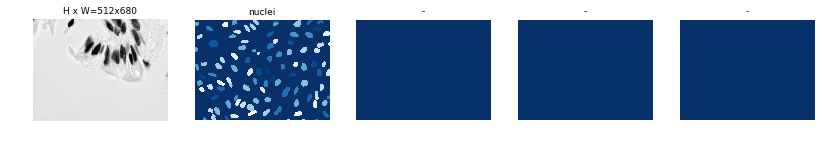

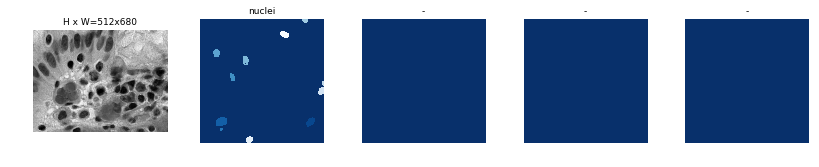

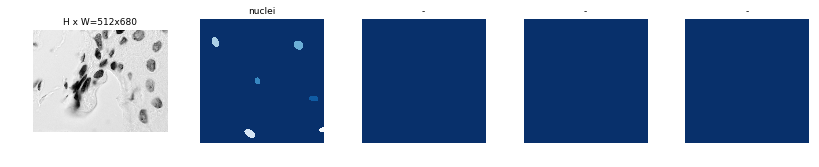

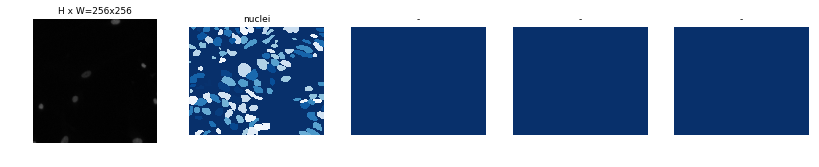

In [16]:
image_ids = np.random.choice(dataset_test.image_ids, 4)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [17]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [18]:
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [19]:
model.train(dataset_train, dataset_val, 
                learning_rate=config.LEARNING_RATE,
                epochs=10, 
                layers="all", clbcks=[LossHistory()])


Starting at epoch 0. LR=0.01

Checkpoint Path: /neptune/logs/dsb20180308T1550/mask_rcnn_dsb_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (BatchN

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
300/300 [==============================] - 757s 3s/step - loss: 1.2340 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.4788 - mrcnn_class_loss: 0.1632 - mrcnn_bbox_loss: 0.2639 - mrcnn_mask_loss: 0.2602 - val_loss: 0.5118 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.2476 - val_mrcnn_class_loss: 0.0392 - val_mrcnn_bbox_loss: 0.0646 - val_mrcnn_mask_loss: 0.1481
Epoch 2/10
300/300 [==============================] - 730s 2s/step - loss: 0.9659 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.3295 - mrcnn_class_loss: 0.1676 - mrcnn_bbox_loss: 0.1799 - mrcnn_mask_loss: 0.2494 - val_loss: 0.5008 - val_rpn_class_loss: 0.0164 - val_rpn_bbox_loss: 0.2379 - val_mrcnn_class_loss: 0.0559 - val_mrcnn_bbox_loss: 0.0746 - val_mrcnn_mask_loss: 0.1160
Epoch 3/10
300/300 [==============================] - 728s 2s/step - loss: 0.8914 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.2928 - mrcnn_class_loss: 0.1503 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2479 - val_loss: 0.3193 - val_rpn_class_l

In [20]:
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /neptune/logs/dsb20180308T1550/mask_rcnn_dsb_0010.h5


original_image           shape: (512, 512, 3)         min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max:  512.00000
gt_class_id              shape: (15,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (15, 4)               min:    0.00000  max:  484.00000
gt_mask                  shape: (512, 512, 15)        min:    0.00000  max:    1.00000


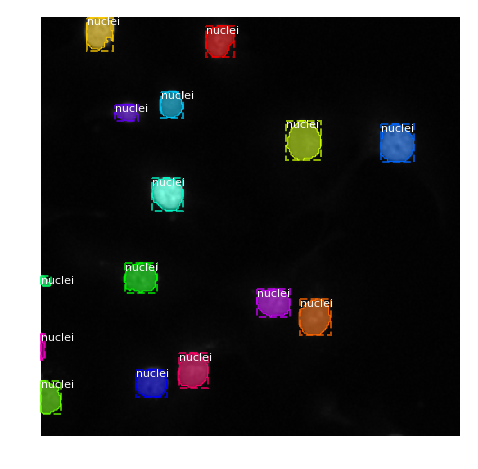

In [21]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 512, 512, 3)      min:    0.00000  max:  255.00000
image_metas              shape: (1, 10)               min:    0.00000  max:  512.00000


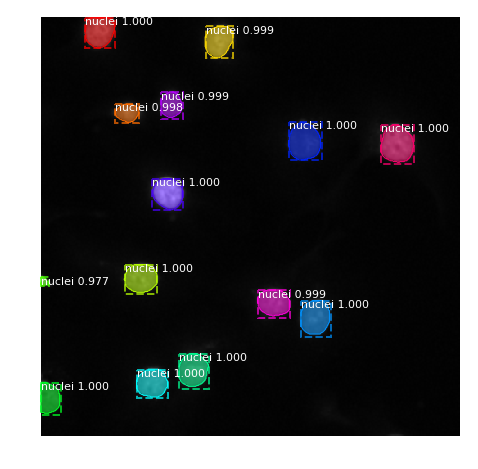

In [22]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [23]:
raw_predictions = []
for test_id in dataset_test.image_ids:
    test_image1 = dataset_test.load_image(test_id, 0)
    pred = model.detect([test_image1], verbose=0)
    pred = pred[0]
    sc = pred['scores']
    pred = pred['masks']
    raw_predictions.append((pred, sc))

In [24]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [25]:
def numpy2encoding_no_overlap(predicts, img_name, scores):
    sum_predicts = np.sum(predicts, axis=2)
    rows, cols = np.where(sum_predicts>=2)
    
    for i in zip(rows, cols):
        instance_indicies = np.where(np.any(predicts[i[0],i[1],:]))[0]
        highest = instance_indicies[0]
        predicts[i[0],i[1],:] = predicts[i[0],i[1],:]*0
        predicts[i[0],i[1],highest] = 1
    
    ImageId = []
    EncodedPixels = []
    print(predicts.shape)
    for i in range(predicts.shape[2]): 
        rle = rle_encoding(predicts[:,:,i])
        if len(rle)>0:
            ImageId.append(img_name)
            EncodedPixels.append(rle)    
    return ImageId, EncodedPixels

In [26]:
new_test_ids = []
rles = []
for id, raw_pred in zip(test_ids, raw_predictions):
    ids, rle = numpy2encoding_no_overlap(raw_pred[0], id, raw_pred[1])
    new_test_ids += ids
    rles += rle

(256, 256, 96)
(520, 696, 30)
(260, 347, 91)
(256, 256, 12)
(519, 162, 50)
(512, 640, 22)
(524, 348, 113)
(256, 256, 37)
(256, 256, 30)
(512, 680, 77)
(256, 256, 6)
(524, 348, 115)
(256, 256, 11)
(256, 256, 43)
(520, 348, 204)
(512, 640, 17)
(519, 253, 55)
(519, 161, 51)
(260, 347, 125)
(256, 256, 13)
(520, 696, 26)
(256, 256, 10)
(512, 640, 21)
(512, 680, 51)
(520, 696, 33)
(256, 256, 5)
(256, 256, 47)
(256, 256, 10)
(390, 239, 37)
(519, 253, 55)
(512, 640, 20)
(256, 256, 10)
(256, 256, 34)
(512, 680, 16)
(519, 253, 56)
(256, 256, 9)
(512, 680, 65)
(519, 162, 51)
(524, 348, 67)
(520, 696, 30)
(519, 161, 62)
(512, 680, 28)
(512, 640, 3)
(256, 256, 83)
(520, 348, 239)
(260, 347, 116)
(256, 256, 60)
(256, 256, 6)
(512, 640, 18)
(520, 348, 206)
(512, 640, 4)
(256, 256, 14)
(260, 347, 120)
(520, 348, 219)
(256, 256, 12)
(519, 253, 63)
(256, 256, 8)
(512, 680, 27)
(524, 348, 68)
(256, 256, 12)
(512, 640, 6)
(512, 680, 23)
(512, 680, 62)
(256, 256, 20)
(256, 256, 7)


In [27]:
df = pd.DataFrame({ 'ImageId' : new_test_ids , 'EncodedPixels' : rles})
df.to_csv('submission.csv', index=False, columns=['ImageId', 'EncodedPixels'])